In [2]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr
import regex as re

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

# IO

In [3]:
cs = dict()

db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [ 

    
    dict(name="base_4cores", id="cvd1a-1drecycling_cvode_4cores", guard_replace = False, unnormalise = False), 
    dict(name="pvode_4cores", id="cvd1b-pvode", guard_replace = False, unnormalise = False), 
    dict(name="pvode_diags_4cores", id="cvd1c-pvode_diags_branch_pvode", guard_replace = False, unnormalise = False), 

]

for case in toload:
    cs[case["name"]] = Load.case_1D(db.casepaths[case["id"]], guard_replace = case["guard_replace"], unnormalise = case["unnormalise"])
    cs[case["name"]].ds.load()

/ssd_scratch/scripts/.venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Skipping unnormalisation


/ssd_scratch/scripts/.venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Skipping unnormalisation


/ssd_scratch/scripts/.venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Skipping unnormalisation


# Case comparison

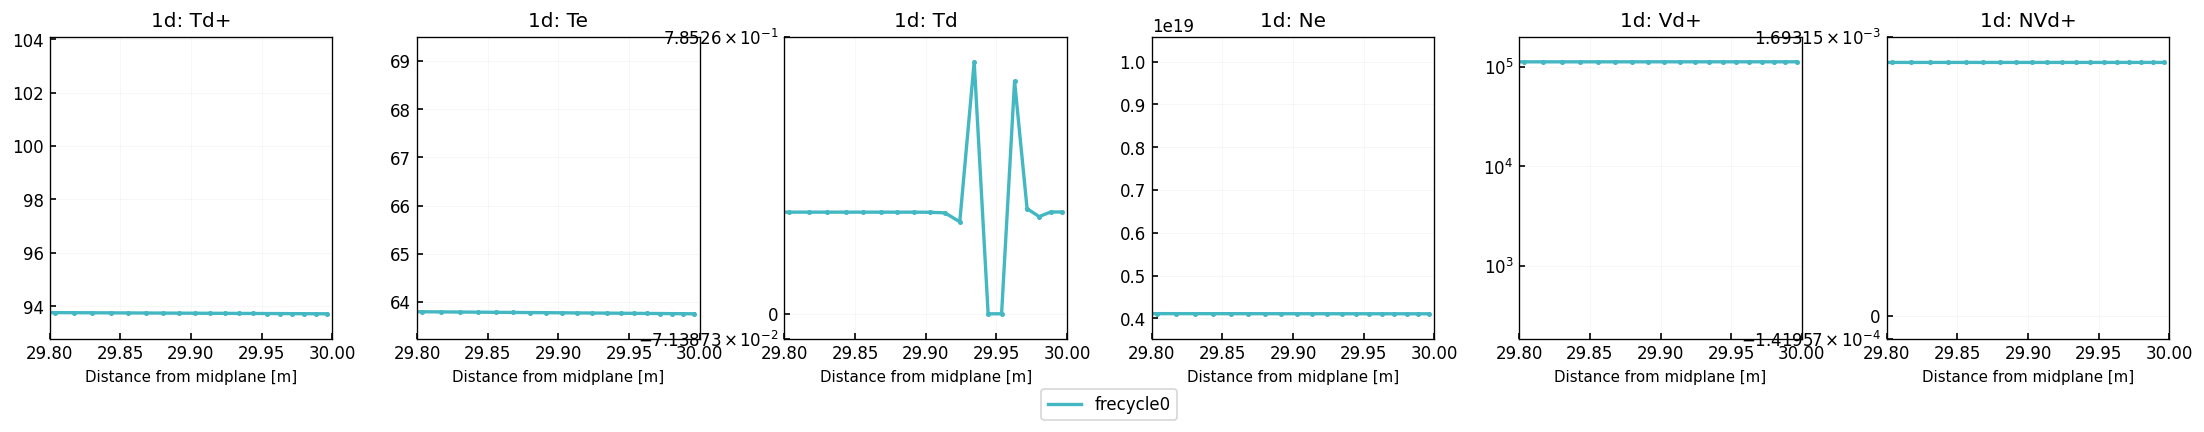

In [61]:
toplot = {}
for name in cs:
# for name in ["diags"]:
    ds = cs[name].ds
    if "t" in ds.dims:
        ds = ds.isel(t=-1)
    toplot[name] = ds

lineplot(
    toplot,
    clean_guards = True,
    params = ["Td+", "Te", "Td", "Ne", "Vd+", "NVd+"],
    regions = ["1d"],
    xlims=(29.8,30)
    # xlims=(0,1)
)

In [14]:
(1+0.24)/(1+4.2) * 13.58 * 3/4 * np.pi

7.630082742162871

# Performance

In [11]:
cs.keys()

dict_keys(['base_4cores', 'pvode_4cores'])

In [14]:
ds = cs["pvode_4cores"].ds
# ds.data_vars

nonlin_fails not found in pvode_4cores
nonlin_fails not found in pvode_diags_4cores
lin_per_nonlin not found in pvode_4cores
lin_per_nonlin not found in pvode_diags_4cores
precon_per_function not found in pvode_4cores
precon_per_function not found in pvode_diags_4cores
cvode_last_step not found in pvode_4cores
cvode_last_step not found in pvode_diags_4cores


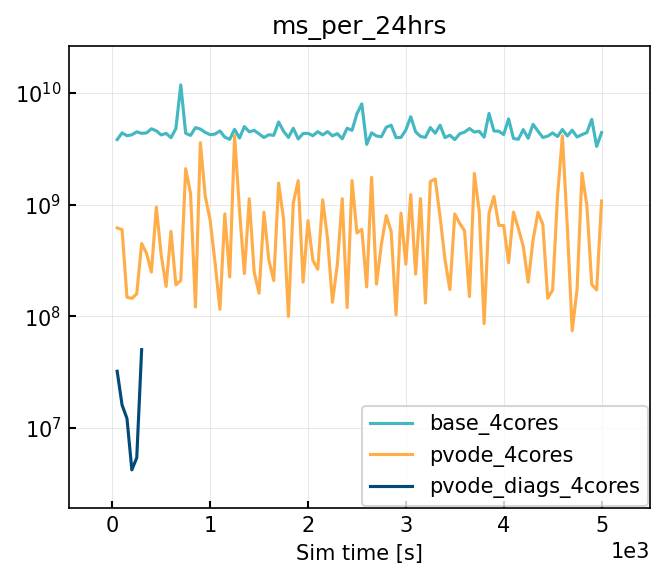

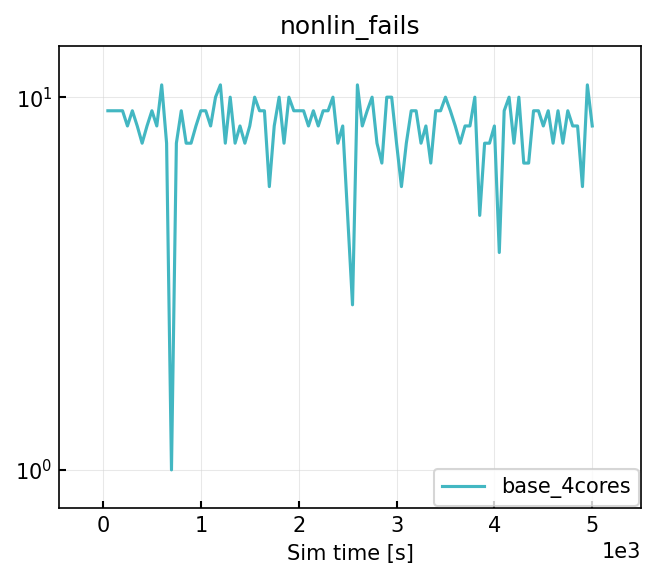

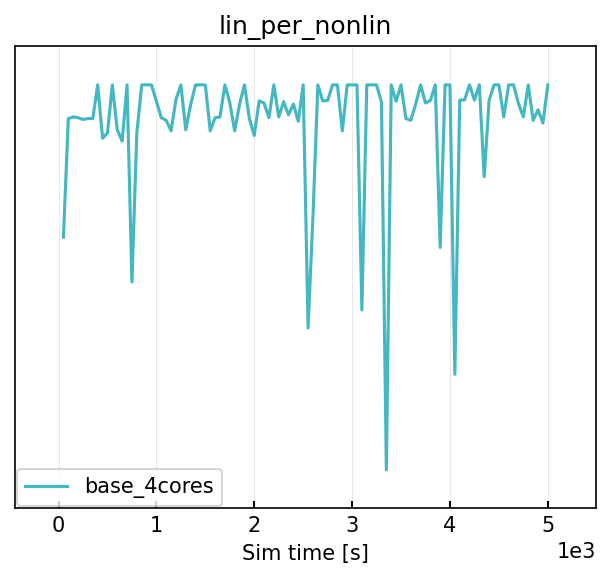

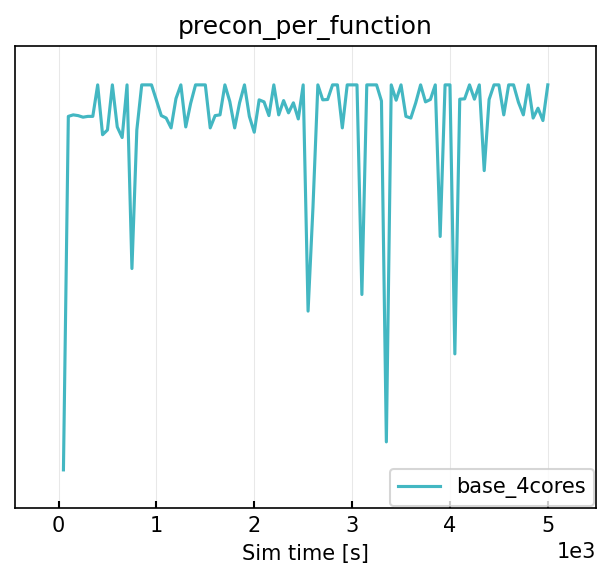

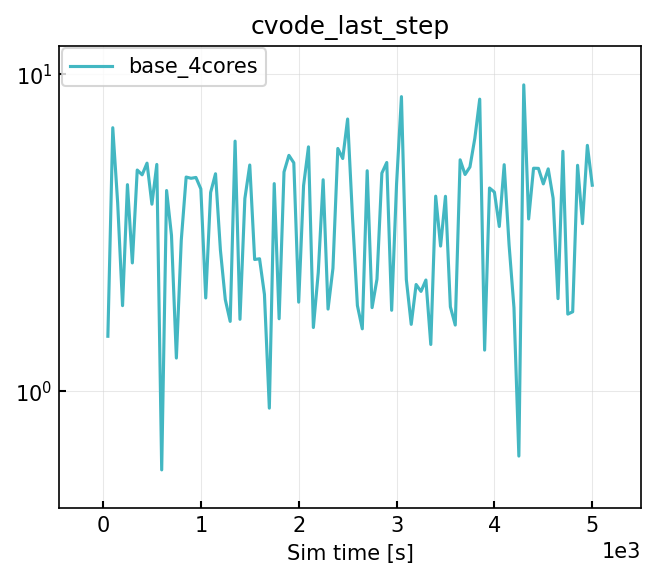

In [7]:
# cs["pvode_4cores"].ds.hermesm.get_cvode_metrics()
plot_cvode_performance(cs, logscale = True)

# Convergence

In [ ]:
cs["example"].ds.hermesm.get_cvode_metrics()

/ssd_scratch/scripts/sdtools/hermes3/accessors.py:7: AccessorRegistrationWarning: registration of accessor <class 'hermes3.accessors.HermesDataArrayAccessor'> under name 'hermesm' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  @register_dataarray_accessor("hermesm")
/ssd_scratch/scripts/sdtools/hermes3/accessors.py:44: AccessorRegistrationWarning: registration of accessor <class 'hermes3.accessors.HermesDatasetAccessor'> under name 'hermesm' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  @register_dataset_accessor("hermesm")


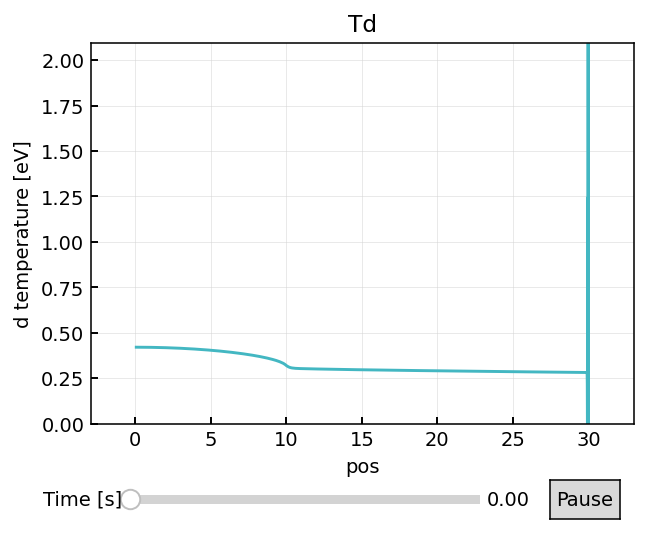

No such comm: 41ca2db46e2e4692825aab3a9907b3a6


In [67]:
plt.close("all")

ds = cs["frecycle0"].ds.isel(pos=slice(2,-2))
xbout.plotting.animate.animate_line(ds["Td"])

In [5]:
cs.keys()

dict_keys(['base_4cores'])

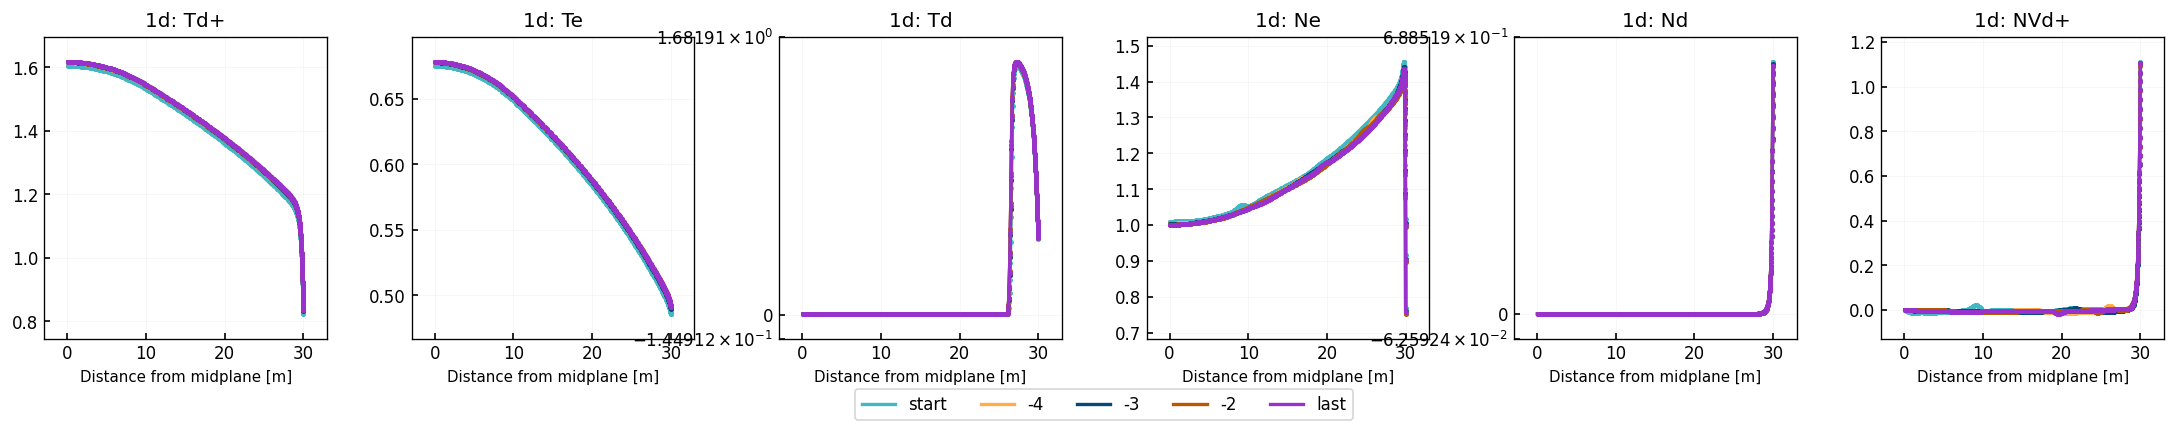

In [3]:
case = "base_4cores"

lineplot(
    {
        "start":cs[case].ds.isel(t=0),
        "-4":cs[case].ds.isel(t=-4),
        "-3":cs[case].ds.isel(t=-3),
        "-2":cs[case].ds.isel(t=-2),
        "last":cs[case].ds.isel(t=-1),

    },
    clean_guards = True,
    params = ["Td+", "Te", "Td", "Ne", "Nd", "NVd+"],
    regions = ["1d"],
    lw = 2,
    # markersize = 0,
    # xlims = (29, 30.2)
    # xlims = (0,1)
)

In [7]:
self = Balance1D(cs["base_4cores"].ds, ignore_errors = True, normalised = True)
self.get_terms()
self.get_tallies()
self.print_balances()

***Warning, species choice currently hardcoded

***Warning, you must have guard cells loaded in

Warning! Sd+_sheath not found, results may be incorrect
Warning! Rar not found, results may be incorrect
Warning! Ee_sheath not found, results may be incorrect
Warning! Ed+_sheath not found, results may be incorrect
Sheath diagnostics not available, attempting to reconstruct
Reconstructing sheath fluxes

Particle flows [s^-1]
Check recycle fraction against expectations
----------------------
Sd+_src: 0.000e+00
Sd_src: 0.000e+00
Sd+_feedback: -2.840e+04
Sd+_iz: 3.412e+06
Sd+_rec: -2.550e+02
Sd_target_recycle: 3.411e+06
Sd+_sheath: -3.411e+06
----------------------
Derived quantities
----------------------
sources_sum: -2.840e+04
recycle_frac: 1.000e+00
net_iz: 3.411e+06
sources_and_net_iz: 3.383e+06
sheath_sum: 4.657e-10
----------------------
Diagnostic output
----------------------
Imbalance: Src + IZ+REC + Sheath: 3.383e+06


Heat flows [MW]
----------------------
Pd+_src: 9.569e+00
Pe_sr

Pd_src is zero, dropping
Rar is zero, dropping


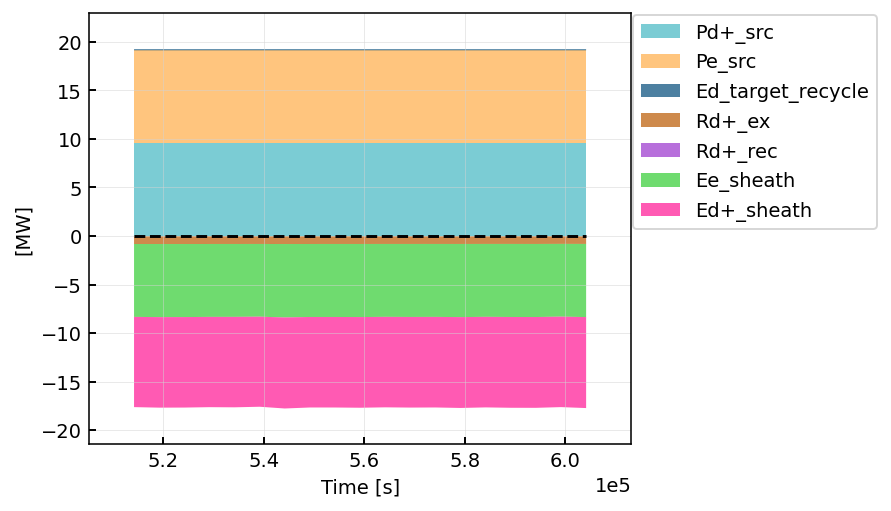

In [8]:
self.plot_heat_balance()

In [ ]:
%matplotlib inline

In [ ]:
%matplotlib inline

In [ ]:
%matplotlib inline

In [ ]:
%matplotlib inline

In [ ]:
%matplotlib inline

In [ ]:
%matplotlib inline

In [ ]:
%matplotlib inline

In [ ]:
%matplotlib inline

In [ ]:
%matplotlib inline

In [ ]:
%matplotlib inline

In [ ]:
%matplotlib inline

# Balances

In [8]:
cs.keys()

dict_keys(['frecycle0'])

In [45]:
self = Balance1D(cs["frecycle0"].ds, ignore_errors = True, normalised = True)
self.get_terms()
self.get_tallies()
self.print_balances()

***Warning, species choice currently hardcoded

***Warning, you must have guard cells loaded in

Warning! Rar not found, results may be incorrect

Particle flows [s^-1]
Check recycle fraction against expectations
----------------------
Sd+_src: 0.000e+00
Sd_src: 0.000e+00
Sd+_feedback: 2.830e+06
Sd+_iz: 6.979e+01
Sd+_rec: -6.980e+01
Sd_target_recycle: 0.000e+00
Sd+_sheath: -2.824e+06
----------------------
Derived quantities
----------------------
sources_sum: 2.830e+06
recycle_frac: 0.000e+00
net_iz: -3.039e-03
sources_and_net_iz: 2.830e+06
sheath_sum: -2.824e+06
----------------------
Diagnostic output
----------------------
Imbalance: Src + IZ+REC + Sheath: 5.400e+03


Heat flows [MW]
----------------------
Pd+_src: 9.569e+00
Pe_src: 9.569e+00
Pd_src: 0.000e+00
Rd+_ex: 0.000e+00
Rd+_rec: 0.000e+00
Rar: 0.000e+00
Ed_target_recycle: 0.000e+00
Ee_sheath: -6.296e+00
Ed+_sheath: -6.617e+00
----------------------
Derived quantities
----------------------
sources_sum: 1.914e+01
R_hydr_sum:

## Reconstruct diagnostics 

In [53]:
# ds = ds["frecycle0"].ds

self.get_properties()
ds = self.ds
qe = self.qe
Zi = self.Zi
Mi = self.Mi
Me = self.Me
Ge = self.Ge
sheath_ion_polytropic = self.sheath_ion_polytropic
phi_wall = 0

dasheath = self.get_target_value(ds["da"])
dv = ds.isel(pos=-3)["dv"].values

visheath = self.get_target_value(ds["Vd+"])
vesheath = self.get_target_value(ds["Ve"])

nesheath = self.get_target_value(ds["Ne"])
nisheath = self.get_target_value(ds["Nd+"])

tesheath = self.get_target_value(ds["Te"])
tisheath = self.get_target_value(ds["Td+"])

cssheath = np.sqrt((sheath_ion_polytropic * tisheath*qe + Zi * tesheath*qe) / Mi)   # [m/s] Bohm criterion sound speed

ion_sum = Zi * nisheath * cssheath   # Sheath current
phisheath = tesheath * np.log(np.sqrt(tesheath / (Me * 2*np.pi)) * (1 - Ge) * nesheath / ion_sum)   # [V] sheath potential, (note Neumann BC)
vesheath = np.sqrt(tesheath / (2*np.pi * Me)) * (1 - Ge) * np.exp(-(phisheath - phi_wall)/tesheath)


pfi_sheath = -1 * visheath * nisheath * dasheath   # [s^-1] ion particle flux into domain 
pfe_sheath = -1 * vesheath * nesheath * dasheath   # [s^-1] electron particle flux into domain 


hfi_sheath = pfi_sheath * (self.gamma_i * tisheath*qe + 0.5*Mi*cssheath**2) * 1e-6   # [MW] electron heat flux into domain
hfe_sheath = pfe_sheath * (self.gamma_e * tesheath*qe + 0.5*Me*vesheath**2) * 1e-6   # [MW] electron heat flux into domain

q = ((self.gamma_e - 2.5) * tesheath - 0.5 * Me * vesheath**2) * nesheath * vesheath

self.hbal["Ee_sheath"] = hfe_sheath 
self.hbal["Ed+_sheath"] = hfi_sheath
self.get_tallies()

print(f"phisheath = {phisheath:.6f}")
print(f"phi_wall = {phi_wall:.6f}")
print(f"Me = {Me:.6f}")
print(f"gamma_e = {self.gamma_e:.1f}")
print(f"tesheath = {tesheath:.6f}")
print(f"nesheath = {nesheath:.6f}")
print(f"vesheath = {vesheath:.6f}")
print(f"q_e = {q:.6f}")
print(f"da = {dasheath:.5e}")
print(f"dv = {dv:.5e}")


hfe_sheath.values
# 

1.7425008415486056
phisheath = 1.742501
phi_wall = 0.000000
Me = 0.000545
gamma_e = 4.5
tesheath = 0.637524
nesheath = 0.410922
vesheath = 0.887330
q_e = 0.464834
da = 6.01856e+06
dv = 4.51724e+07


array(-6.29620313)

In [43]:
np.log(np.sqrt(tesheath ) * (1 - Ge) * nesheath).values

array(-inf)

In [44]:
tesheath

<xarray.DataArray 'Te' ()>
array(0.63752399)
Coordinates:
    dx       float64 9.579e+05
    dz       float64 6.283
Attributes:
    current_time_index:  1
    cell_location:       CELL_CENTRE
    conversion:          100.0
    direction_y:         Standard
    direction_z:         Standard
    long_name:           e temperature
    source:              evolve_pressure
    species:             e
    standard_name:       temperature
    time_dimension:      t
    units:               eV
    metadata:            {'BOUT_VERSION': 5.2, 'Bnorm': 1.0, 'Cs0': 97871.514...
    options:             # 1D system with:\n#  - no-flow boundary on lower Y ...
    geometry:            
    units_type:          hermes

In [54]:
self.print_balances()


Particle flows [s^-1]
Check recycle fraction against expectations
----------------------
Sd+_src: 0.000e+00
Sd_src: 0.000e+00
Sd+_feedback: 2.830e+06
Sd+_iz: 6.979e+01
Sd+_rec: -6.980e+01
Sd_target_recycle: 0.000e+00
Sd+_sheath: -2.824e+06
----------------------
Derived quantities
----------------------
sources_sum: 2.830e+06
recycle_frac: 0.000e+00
net_iz: -3.039e-03
sources_and_net_iz: 2.830e+06
sheath_sum: -2.824e+06
----------------------
Diagnostic output
----------------------
Imbalance: Src + IZ+REC + Sheath: 5.400e+03


Heat flows [MW]
----------------------
Pd+_src: 9.569e+00
Pe_src: 9.569e+00
Pd_src: 0.000e+00
Rd+_ex: 0.000e+00
Rd+_rec: 0.000e+00
Rar: 0.000e+00
Ed_target_recycle: 0.000e+00
Ee_sheath: -9.444e+00
Ed+_sheath: -8.841e+00
----------------------
Derived quantities
----------------------
sources_sum: 1.914e+01
R_hydr_sum: 0.000e+00
R_imp_sum: 0.000e+00
R_sum: 0.000e+00
R_and_sources_sum: 1.914e+01
sheath_sum: -1.829e+01
----------------------
Diagnostic output
----

In [ ]:
# hfe_sheath = self.gamma_i * pfi_sheath * tisheath*qe * 1e-6   # [MW] electron heat flux into domain
# pf_sheath[-1]

# fig, axes = plt.subplots(1,3, figsize = (10,3))
# t = ds["t"]


# ax = axes[0]
# ax.plot(t, pfi_sheath, label = "Calculation")
# ax.plot(t, self.pbal["Sd+_sheath"], label = "Hermes-3 diagnostic")
# ax.set_title("Sheath particle flow")

# ax = axes[1]
# ax.plot(t, hfi_sheath, label = "Calculation")
# ax.plot(t, self.hbal["Ed+_sheath"], label = "Hermes-3 diagnostic")
# ax.set_title("Sheath ion heat flow [s]")

# ax = axes[2]
# ax.plot(t, hfe_sheath, label = "Calculation")
# ax.plot(t, self.hbal["Ee_sheath"], label = "Hermes-3 diagnostic")
# ax.set_title("Sheath electron heat flow [s]")

# ax.set_yscale("symlog")

# for ax in axes:
#     ax.legend(fontsize = "x-small")

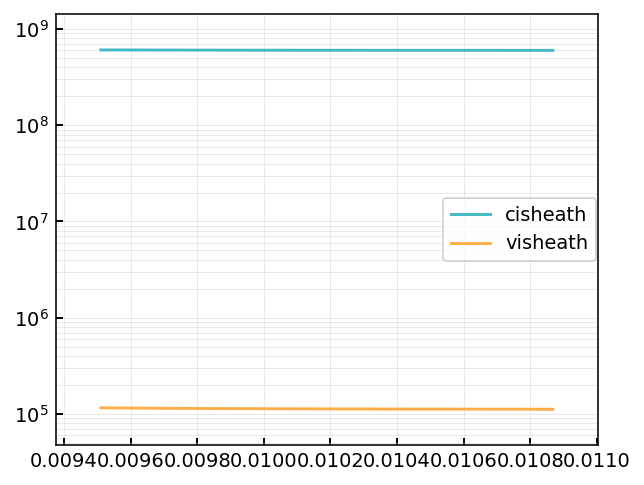

In [86]:
cisheath = np.sqrt(1*tisheath + tesheath)*constants("q_e")/(constants("mass_p") * 2)
# cisheath = np.sqrt(1*tisheath)*constants("q_e")/(constants("mass_p") * 2)

fig, ax =plt.subplots()
ax.plot(t, cisheath, label = "cisheath")
ax.plot(t, visheath, label = "visheath")
ax.legend()
ax.set_yscale("log")

# Balances Matt

In [15]:
dataSets = {}

def loadData(fileName,dataSets,folderPath,filePath):
    #----- Load data
    print(os.path.join(folderPath,filePath))
    ds = Load.case_1D(os.path.join(folderPath,filePath),use_squash=True,verbose=True).ds     # Load, extract, normalise, and guard replace outputs
    ds = ds.isel(pos=slice(2,-2))                                                            # Crop off outer and inner guard cells
    
    #----- Time manipulating
    ds["t"] = ds["t"]*1e3                                                                    # Convert t into ms from s
    ds["timeNorm"] = ds["t"].values-ds["t"].values[0]                                        # Set t[0]==0

    #----- Input Powers
    electronInput = (3./2.)*(ds["Pe_src"] *ds["dv"])                                         # Pe_src is in Pa.s^-1 which is J.m^-3.s^-1 = W.m^-3
    ionInput      = (3./2.)*(ds["Pd+_src"]*ds["dv"])
    ds["electronInputSum"] = electronInput.sum("pos")
    ds["ionInputSum"]      = ionInput.sum("pos")
    ds["totalPowInput"]    = ds["electronInputSum"]+ds["ionInputSum"]

    #----- Detachment Front Position
    tempVal    = 5.0 # eV
    tempMean   = (ds["Te"].values+ds["Td+"].values)/2.
    xInterp    = np.linspace(ds["pos"].values[0],ds["pos"].values[-1],int(10.*len(ds["pos"].values)))
    interpFunc = interp1d(ds["pos"].values,tempMean,axis=1)
    tempMeanHR = interpFunc(xInterp)
    ds["detLoc"] = ds["pos"].values[-1]-xInterp[np.argmin(np.abs(tempMeanHR-tempVal),axis=1)]
    ds["detLocRaw"] = ds["pos"].values[-1]-ds["pos"].values[np.argmin(np.abs(tempMean-tempVal),axis=1)]
    
    #----- Final timestep
    finalTime = 1e-3*ds["t"].values[-1]/ds["t"].attrs["conversion"]
    print(fileName,"Final timestep to be used for time dependent power: ",finalTime)

    #----- Total Pressures
    ds["Pp"] = ds["Pe"]+ds["Pd+"]

    ds["totalRadArPow"]    = ds["Rar"]*ds["dv"]
    ds["totalRadArPowSum"] = ds["totalRadArPow"].sum("pos")

    #----- Radiation losses
    totalRar  =  np.abs((ds["dv"]*ds["Rar"]).sum("pos"))
    totalRex  =  np.abs((ds["dv"]*ds['Rd+_ex']).sum("pos"))
    totalRrec = -np.abs((ds["dv"]*ds['Rd+_rec']).sum("pos"))
    totalRrad = (totalRar.values+totalRex.values+totalRrec.values)
    ds["totalRar"]  = totalRar
    ds["totalRex"]  = totalRex
    ds["totalRrec"] = totalRrec
    ds["totalRrad"] = totalRrad

    dataSets[fileName] = ds
    return dataSets

In [ ]:
folderPath = "/path/to/file/"

filePaths = ["spr45_nD_fimp-0-0_udens-1-86e20",
             "spr45_nD_linPow_3x_fimp-6-0-2-3"]
fileNames = ["fimp-0-0",
             "fimp-6-0"]

for filePath,fileName in zip(filePaths,fileNames):
    dataSets = loadData(fileName,dataSets,folderPath,filePath)

# Cross-check with collect

In [5]:

def get_var(name):
    return collect(name, path=r"/ssd_scratch/hcases/balances1d/bl1a-1drecycling_base", yguards = True, info = False, tind = -1)

d = {}
for param in ["NVd+", "Pd+_src", "Pe_src", "dx", "dy", "dz", "J", "Nnorm", "Tnorm", "rho_s0"]:
    d[param] = get_var(param).squeeze()
    
d["Pnorm"] = d["Nnorm"]*d["Tnorm"]*constants("q_e")

d["dv"] = d["dx"]*d["dy"]*d["dz"]*d["J"]#* (d["rho_s0"]**3)

d["Pd+_src"] *= d["Pnorm"]
d["Pe_src"] *= d["Pnorm"]


In [9]:

def get_var(name):
    return collect(name, path=r"/ssd_scratch/hcases/balances1d/bl1ai-test_base_new_master", yguards = True, info = False, tind = -1)

d = {}
for param in ["NVd+"]:
    d[param] = get_var(param).squeeze()

d["NVd+"][-5:]

BoutArray([ 1.03136853,  1.07495699,  1.0713104 , -1.0713104 ,
            0.        ])

In [37]:


Pi = (d["Pd+_src"] * d["dv"])[2:-2].sum() * 1e-6 * 3/2

Pi

BoutArray(1533.05464096)

In [ ]:
# Pd+_src: 1.566e+02
# Pe_src: 1.566e+02

In [17]:
d["dv"]

KeyError: 'dv'

Pd_src is zero, dropping
Rd+_ex is zero, dropping
Rd+_rec is zero, dropping
Rar is zero, dropping
Ed_target_recycle is zero, dropping


AttributeError: 'Dataset' object has no attribute 't'

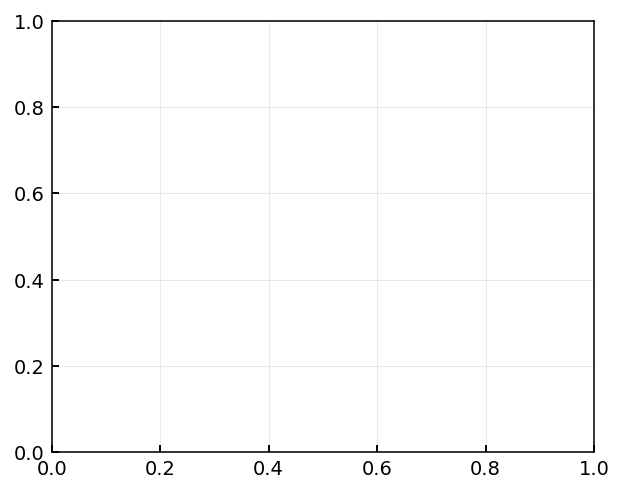

In [9]:
fig, ax = plt.subplots()

pos = {}
neg = {}

for key in self.hbal:
    
    if self.time:
        val = self.hbal[key][-1]
    else:
        val = self.hbal[key]
    
    if val > 0:
        pos[key] = self.hbal[key]
    elif val < 0:
        neg[key] = self.hbal[key]
    else:
        print(f"{key} is zero, dropping")

# pos = {k: v for k, v in sorted(pos.items(), key=lambda item: item[1])}


        
t = self.ds.t
ax.stackplot(t, list(pos.values()), labels = pos.keys(), baseline = "zero", alpha = 0.7)
ax.stackplot(t, list(neg.values()), labels = neg.keys(), baseline = "zero", alpha = 0.7)
ax.hlines(0, t[0], t[-1], color = "k", linestyle = "--")

ax.legend(loc = "upper left", bbox_to_anchor = (1,1))
ax.set_ylabel("[MW]")
ax.set_xlabel("Time [s]")
# Pd+_src: 1.566e+02
# Pe_src: 1.566e+02
# Pd_src: 0.000e+00
# Rd+_ex: -9.589e+00
# Rd+_rec: -5.753e-04
# Ed_target_recycle: 1.372e+00
# Ee_sheath: -1.081e+02
# Ed+_sheath: -1.002e+02

# Check cell fluxes against sources

In [31]:
cs.keys()

dict_keys(['diags'])

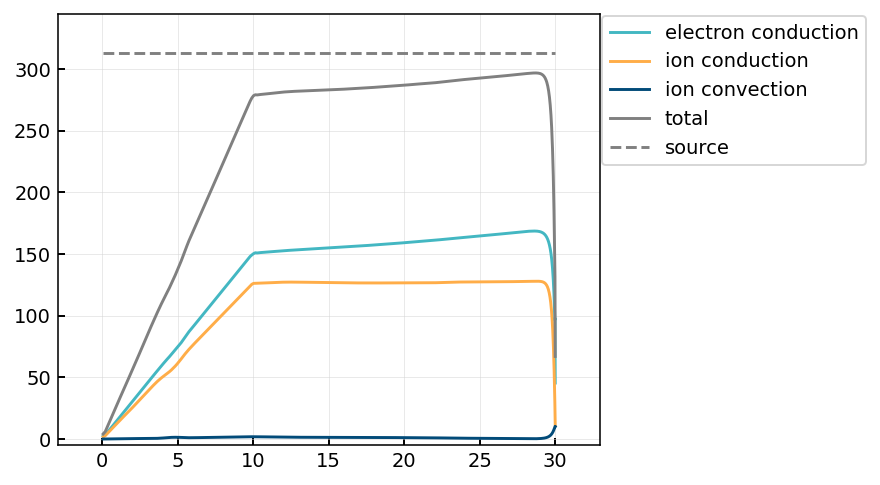

In [43]:
ds = cs["diags"].ds.isel(t=-1, pos = slice(2,-2))

src = ((ds["Pd+_src"] + ds["Pe_src"]) * ds["dv"]).sum("pos") * 1e-6 * 3/2

# hfe_cond = 2293.8117*ds["Te"]**(5/2)*np.gradient(ds["Te"], ds["pos"]) * -1e-6
hfe_cond = ds["kappa_par_e"] * np.gradient(ds["Te"], ds["pos"]) * ds["da"] * -1e-6 
hfi_cond = ds["kappa_par_d+"] * np.gradient(ds["Td+"], ds["pos"]) * ds["da"] * -1e-6 
hfi_conv = ds["Vd+"] * ds["Pd+"] * 3/2  * 1e-6
hf_tot = hfe_cond + hfi_cond + hfi_conv

fig, ax = plt.subplots()
ax.plot(ds["pos"], hfe_cond, label = "electron conduction")
ax.plot(ds["pos"], hfi_cond, label = "ion conduction")
ax.plot(ds["pos"], hfi_conv, label = "ion convection")
ax.plot(ds["pos"], hf_tot, c = "grey", label = "total")
ax.hlines(src, ds["pos"][0], ds["pos"][-1], label = "source", colors = "grey", linestyle = "--")
ax.set_ylim(-5, ax.get_ylim()[1])
ax.legend(loc = "upper left", bbox_to_anchor=(1,1))

In [68]:
pos = sorted(pos.items(), key=lambda x: x[1][-1])